# **X-ray magic classifier**

Nuestra misión es desarrollar un modelo predictivo capaz de determinar qué parte del cuerpo ha sido radiografiada. Contamos con 

## Librerías, preparativos y carga de datos

In [ ]:
!pip install pandas==0.24

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.1 MB 4.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.2 requires pandas>=1.1, but you have pandas 0.24.0 which is incompatible.
plotnine 0.6.0 requires pandas>=0.25.0, but you have pandas 0.24.0 which is incompatible.
mizani 0.6.0 requires pandas>=0.25.0, but you have pandas 0.24.0 which is incompatible.
google-colab 1.0.0 requires pandas>=1.1.0; python_version >= "3.0", but you have pandas 0.24.0 which is incompatible.
fbprophet 0.7.1 requires pandas>=1.0.4, but you have pandas 0.24.0 which is incompatible.


In [ ]:
!pip install kaggle
!pip install pydicom
!pip install fastai
!conda install -c conda-forge gdcm -y
!pip install -U python-gdcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.6 MB 4.4 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import pydicom
import gdcm


## Cargar imagenes desde Kaggel

A continuación vamos a proceder a descargar las imagenes de KAGGEL:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
path = !kaggle competitions download -c edemdataproject4

In [ ]:
!unzip edemdataproject4.zip

## Exploración variable Target

Una vez tenemos descargadas las imagenes vamos a realizar la exploración y analisis de TRAIN.CSV:

In [ ]:
# Cargar dataset train
train_data=pd.read_csv('/content/train.csv')

In [ ]:
train_data.head()

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
1,1.2.826.0.1.3680043.8.498.53411283183733547704...,3
2,1.2.826.0.1.3680043.8.498.12955484645689261949...,3
3,1.2.826.0.1.3680043.8.498.10408703585974384892...,3
4,1.2.826.0.1.3680043.8.498.30255106562321206269...,9


Observamos que únicamente contiene el SOPinstanceUID de la imagen y la variable TARGET, es decir de que parte del cuerpo es la imagen. A continuación vamos a realizar la exploración de la variable TARGET:

In [ ]:
# Describe target variable ¿esto aqui no tiene mucho sentido no?
train_data.Target.describe() 

count    1278.000000
mean        6.906886
std         5.889076
min         0.000000
25%         3.000000
50%         3.000000
75%        11.750000
max        21.000000
Name: Target, dtype: float64

In [ ]:
# Comprobación no hay datos nulos
train_data.Target.isnull().sum()

0

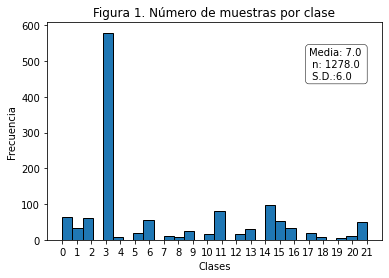

In [ ]:
# Distribución de la variable Target
res = train_data.Target.describe()  
m = round(res['mean'],0) 
sd = round(res['std'],0)
n = round(res['count'],0)

x = train_data.Target
plt.hist(x, edgecolor='black', bins=30)
plt.xticks(np.arange(0, 22, step=1))
plt.title('Figura 1. Número de muestras por clase')
plt.ylabel('Frecuencia')
plt.xlabel('Clases')
props = dict(boxstyle='round', facecolor='white', lw=0.5)
plt.text(17, 450, f'Media: {m} \n n: {n} \n S.D.:{sd}', bbox=props)
#plt.legend(loc='upper left', bbox_to_anchor=(0.73, 0.76))
plt.show()

Se trata claramente de un dataset muy desbalanceado. La clase 3 correspondiente a TÓRAX (clase = 3) presenta 579 casos, muchos más que el resto de clases. Ella sola representa el 45,3% de todos los datos.

In [ ]:
# Recodificar variable numérica a categórica
train.loc[(train_data.Target)==0, 'Target_cat']='Abdomen'
train.loc[(train_data.Target)==1, 'Target_cat']='Tobillo'
train.loc[(train_data.Target)==2, 'Target_cat']='Columna cervical'
train.loc[(train_data.Target)==3, 'Target_cat']='Tórax'
train.loc[(train_data.Target)==4, 'Target_cat']='Clavículas'
train.loc[(train_data.Target)==5, 'Target_cat']='Codo'
train.loc[(train_data.Target)==6, 'Target_cat']='Pies'
train.loc[(train_data.Target)==7, 'Target_cat']='Dedos'
train.loc[(train_data.Target)==8, 'Target_cat']='Antebrazo'
train.loc[(train_data.Target)==9, 'Target_cat']='Mano'
train.loc[(train_data.Target)==10, 'Target_cat']='Cadera'
train.loc[(train_data.Target)==11, 'Target_cat']='Rodilla'
train.loc[(train_data.Target)==12, 'Target_cat']='Pierna'
train.loc[(train_data.Target)==13, 'Target_cat']='Columna lumbar'
train.loc[(train_data.Target)==14, 'Target_cat']='Otros'
train.loc[(train_data.Target)==15, 'Target_cat']='Pelvis'
train.loc[(train_data.Target)==16, 'Target_cat']='Hombro'
train.loc[(train_data.Target)==17, 'Target_cat']='Senos paranasales'
train.loc[(train_data.Target)==18, 'Target_cat']='Cráneo'
train.loc[(train_data.Target)==19, 'Target_cat']='Muslo'
train.loc[(train_data.Target)==20, 'Target_cat']='Columna torácica'
train.loc[(train_data.Target)==21, 'Target_cat']='Muñeca'

train.head()

In [ ]:
#pd.crosstab(index=wbr['cnt_cat2'], columns="count")
pd.crosstab(index=train['Target_cat'], columns='count')

In [ ]:
# las categorías ordenadas de más numerosas a menos
train_cat = train_data.groupby(['Target_cat']).size()
train_cat.sort_values(ascending=False)

## Exploración imágenes dataset train

In [ ]:
!pip install os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
import cv2
import numpy as np
import os

In [ ]:
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
#load a DICOM image
from pathlib import Path
import pydicom
import numpy as np
from matplotlib import pyplot as plt
import os 

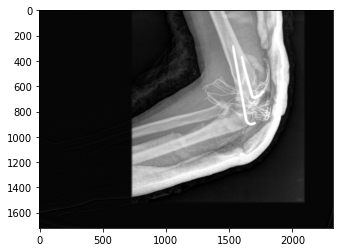

In [ ]:
def load_image(sample_path):
    ds = pydicom.dcmread(sample_path)
    img = ds.pixel_array
    p01 = np.percentile(img.ravel(), 1)
    p99 = np.percentile(img.ravel(), 99)
    img[img > p99] = p99
    img[img < p01] = p01
    if ds.data_element('PhotometricInterpretation').value == 'MONOCHROME1':
        img = np.invert(img)
    img = (img - img.min()) / (img.max() - img.min())
    return img

sample_path2 = Path('/content/train')
sample_path = Path('/content/test/1.2.826.0.1.3680043.8.498.60964782211363234805993194732570333546.dcm' )
img = load_image(sample_path)
plt.imshow(img, cmap='gray')

## Transformar a formato jpg

In [ ]:
# Import Google Drive libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Authenticate with your Google Account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path

In [ ]:
import cv2
import os
import pydicom
import numpy as np
import sys

In [ ]:
mkdir "/content/drive/MyDrive/DP4"

In [ ]:
mkdir "/content/drive/MyDrive/DP4/TRAIN_JPG"

In [ ]:
mkdir "/content/drive/MyDrive/DP4/TEST_JPG"

In [ ]:
inputdir = '/content/train/'
outdir = '/content/drive/MyDrive/DP4/TRAIN_JPG/'
#os.mkdir(outdir)
count=0

train_list = [ f for f in  os.listdir(inputdir)]

for f in train_list:
    ds = load_image(inputdir + f) # read dicom image
    cv2.imwrite(outdir + f.replace('.dcm','.jpg'),(ds*255).astype('uint8')) # write jpg image
    count += 1
    print(count)


In [ ]:
inputdir = '/content/test/'
outdir = '/content/drive/MyDrive/DP4/TEST_JPG/'
#os.mkdir(outdir)
count=0

test_list = [ f for f in  os.listdir(inputdir)]

for f in test_list:
    ds = load_image(inputdir + f) # read dicom image
    cv2.imwrite(outdir + f.replace('.dcm','.jpg'),(ds*255).astype('uint8')) # write jpeg image
    count += 1
    print(count)

In [ ]:
path = sys.argv[1]

for img in os.listdir('/content/drive/MyDrive/DP4/TRAIN'):
    image = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite(os.path.join(path,'new'+img),image)

#I tried to replace <code>sys.argv[1]</code> with the actual path where the images are and the error is:
#<code>cv2.error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgcod

## Pasar las imagenes a carpetas

In [ ]:
path = '/content/drive/MyDrive/DP4/TRAIN'

In [ ]:
path

'/content/drive/MyDrive/DP4/TRAIN'

In [ ]:
import glob

In [ ]:
#Create folder inside train
for folder in list(train_data.Target.unique()):
  os.mkdir(f'/content/drive/MyDrive/DP4/TRAIN_JPG/{folder}')

In [ ]:
file= ("/content/drive/MyDrive/DP4/TRAIN_JPG/1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016.jpg")
print(file)

/content/drive/MyDrive/DP4/TRAIN_JPG/1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016.jpg


In [ ]:
#Move file from train folder
for file in glob.glob("/content/drive/MyDrive/DP4/TRAIN_JPG/*.jpg"):
  folder = train_data.loc[train_data.SOPInstanceUID == file[37:-4]].Target.values[0]
  path_dest = f"/content/drive/MyDrive/DP4/TRAIN_JPG/{folder}/" + file[37:]
  os.system(f"mv {file} {path_dest}")
  count =+ 1
  print(count)

In [ ]:
path ='/content/drive/MyDrive/DP4/TRAIN_JPG'

In [ ]:
path.ls

AttributeError: ignored

In [ ]:
path("/content/drive/MyDrive/DP4/TRAIN_JPG/").ls()

TypeError: ignored

In [ ]:
img = open_image('/content/drive/MyDrive/DP4/TRAIN_PNG/1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125.jpg')
img.show()

NameError: ignored

In [ ]:
img.shape

(1720, 2320)

# **Modelos**

In [ ]:
import cv2
from PIL import Image
import numpy as np

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

In [ ]:
# Import fastai
from fastai.vision import *

# 32 x 32

## Explore Data

In [ ]:
# Load data
batch_size = 256
size = 32
data = ImageDataBunch.from_folder(path='/content/drive/MyDrive/DP4', train="/content/drive/MyDrive/DP4/TRAIN_PNG", test="/content/drive/MyDrive/DP4/TEST_PNG", 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=size, 
                                  bs=batch_size
                                  ).normalize(imagenet_stats)

In [ ]:
#Show classes
data.classes

In [ ]:
# Show samples of data
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
# Initialize learner
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

#Resnet18 es una red neuronal que tiene 18 capas. También hay una ResNet34, ResNet50,… el número siempre indicando el numero de capas que tiene.  ResNet es una arquitectura muy famosa enfocada sobre todo a problemas de visión de computadores.

In [ ]:
learn.model

In [ ]:
# Find optimum learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 1e-2
#lr = 1e-2

In [ ]:
# Train 5 epochs
learn.fit_one_cycle(10, max_lr=slice(lr))

In [ ]:
# Save model
learn.save("score-3733-1")

In [ ]:
# Unfreeze conv layers
learn.unfreeze()

In [ ]:
# Find learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 5e-3

In [ ]:
# Train 5 epochs
learn.fit_one_cycle(5, max_lr=slice(lr/100,lr))

In [ ]:
# Save model
learn.save("score-4236")

# 128 x 128

In [ ]:
batch_size = 64
size = 128
data = ImageDataBunch.from_folder(path='/content/drive/MyDrive/DP4', train="/content/drive/MyDrive/DP4/TRAIN_PNG", test="/content/drive/MyDrive/DP4/TEST_PNG", 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=size, 
                                  bs=batch_size
                                  ).normalize(imagenet_stats)

In [ ]:
# Initialize learner
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [ ]:
# Configure learner with new data and freeze conv layers
learn.data = data
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


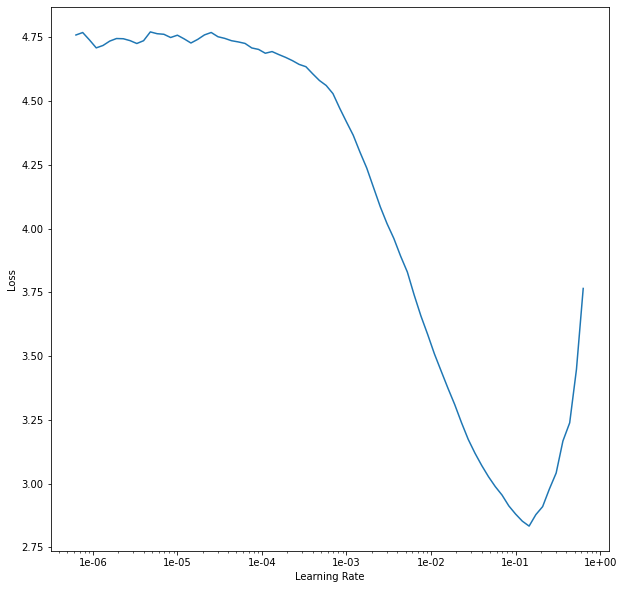

In [ ]:
# Find learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 1e-2

In [ ]:
# Train 5 epochs.
<

epoch,train_loss,valid_loss,accuracy,time
0,0.347454,0.708600,0.858824,04:36
1,0.376014,0.824481,0.858824,04:20
2,0.406477,0.715337,0.866667,04:23
3,0.379700,0.622182,0.878431,04:19
4,0.351062,0.612148,0.890196,04:20


epoch,train_loss,valid_loss,accuracy,time
0,0.307948,0.619859,0.894118,04:25
1,0.306912,0.703378,0.874510,04:31
2,0.323032,0.750569,0.882353,04:25
3,0.331450,0.693337,0.866667,04:25
4,0.321975,0.647804,0.878431,04:23


In [ ]:
# Save model
learn.save("score-7310")

In [ ]:
# Unfreeze conv layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


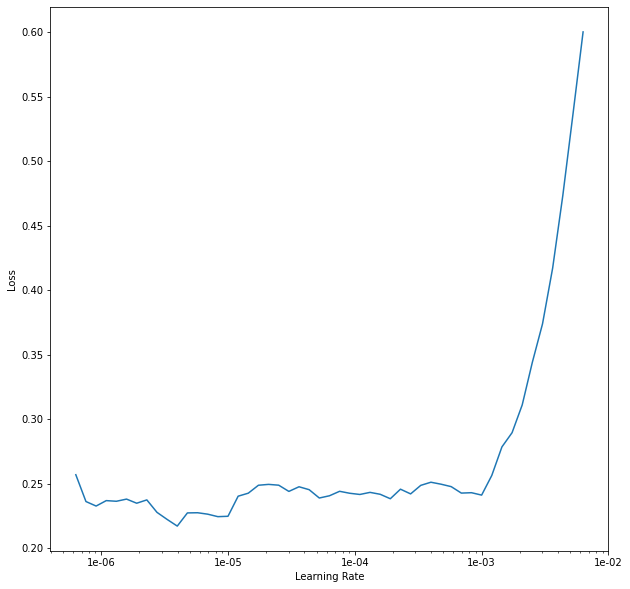

In [ ]:
# Find learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Set learning rate
lr = 1e-4

In [ ]:
# Train 5 epochs
learn.fit_one_cycle(5, max_lr=slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.251136,0.662078,0.874510,04:21
1,0.232370,0.633793,0.882353,04:20
2,0.249336,0.641448,0.886275,04:22
3,0.234944,0.620834,0.886275,04:20
4,0.204963,0.617955,0.890196,04:27


In [ ]:
# Save model
learn.save("score-7378")

# 224 x 224

In [ ]:
# Import fastai
from fastai.vision import *

In [ ]:
# Load data
batch_size = 32 #cantidad de imagenes para cada epoch
size = 256
data = ImageDataBunch.from_folder(path='/content/drive/MyDrive/DP4', train="/content/drive/MyDrive/DP4/TRAIN_JPG", test="/content/drive/MyDrive/DP4/TEST_JPG", 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=size, 
                                  bs=batch_size
                                  ).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:859.)
  return _solve_func(B,A)[0][:,0]


In [ ]:
data.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

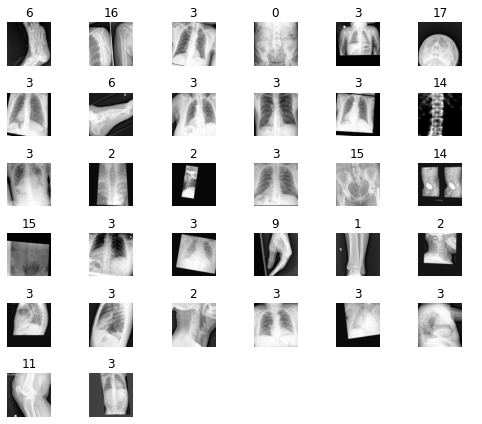

In [ ]:
# Show samples of data
data.show_batch(rows=10, figsize=(7,6))

In [ ]:
# Initialize learner
learn = cnn_learner(data, models.densenet169, metrics=accuracy)

In [ ]:
from torchvision.models.densenet import densenet161

In [ ]:
# Configure learner with new data and freeze conv layers
learn.data = data
learn.freeze()

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 6.92E-03


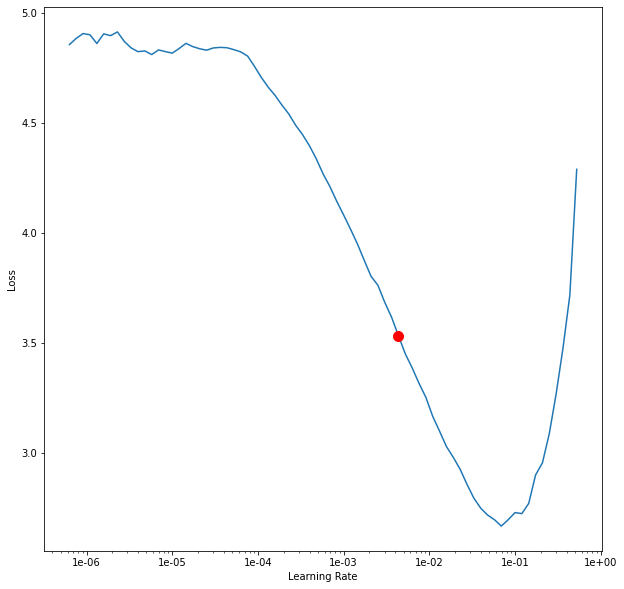

In [ ]:
# Find learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# Set learning rate (está en escala logaritmmica)
lr = 2.09E-03

In [ ]:
# Train 5 epochs
learn.fit_one_cycle(20, max_lr=slice(lr))

In [ ]:
# save results
dicom_dir = '/content/drive/MyDrive/DP4/TEST_JPG'
files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir)]
with open('/content/drive/MyDrive/DP4/submission_densenet169_256_32_20e_freeze.csv', 'w') as sub_f:
  sub_f.write('SOPInstanceUID,Target')
  sub_f.write('\n')
  for f in files:
    file_name = f.split('/')[6].replace('.jpg','')
    image2 = PIL.Image.open(f).convert('RGB')
    t = pil2tensor(image2, dtype=np.float32)
    t.div_(255)
    im = Image(t)
    cat, tensor, probs = learn.predict(im)
    sub_f.write(file_name)
    sub_f.write(',')
    sub_f.write(str(cat))
    sub_f.write('\n')

In [ ]:
# Save model
learn.save("score-densenet169_256_32_20e_freeze")

In [ ]:
# Unfreeze conv layers
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 6.31E-08


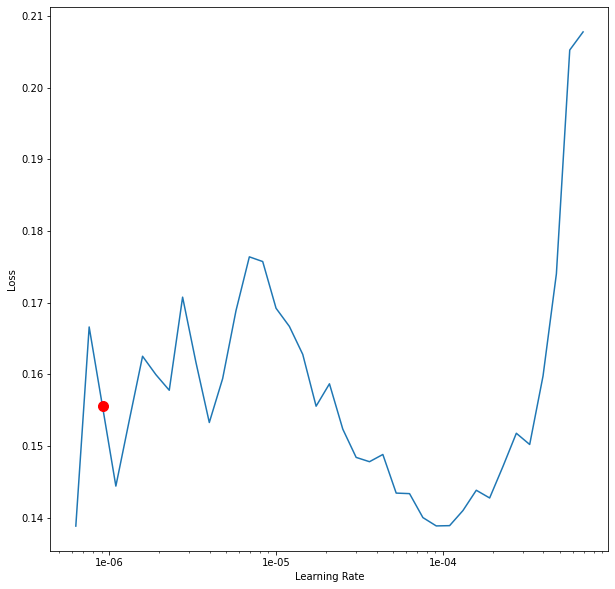

In [ ]:
# Find learning rate
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# Set learning rate 2e-6
lr = 9.12E-07

In [ ]:
# Train 5 epochs
learn.fit_one_cycle(5, max_lr=slice(lr/100,lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.168003,0.540651,0.901961,02:27
1,0.180430,0.547785,0.909804,02:23
2,0.151403,0.556570,0.905882,02:24
3,0.160379,0.545725,0.905882,02:25
4,0.160379,0.546582,0.905882,02:24


In [ ]:
# Save model
learn.save("submission_densenet161_256_5e_unfreeze")

In [ ]:
# save results
dicom_dir = '/content/drive/MyDrive/DP4/TEST_JPG'
files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir)]
with open('/content/drive/MyDrive/DP4/submission_densenet161_256_5e_unfreeze.csv', 'w') as sub_f:
  sub_f.write('SOPInstanceUID,Target')
  sub_f.write('\n')
  for f in files:
    file_name = f.split('/')[6].replace('.jpg','')
    image2 = PIL.Image.open(f).convert('RGB')
    t = pil2tensor(image2, dtype=np.float32)
    t.div_(255)
    im = Image(t)
    cat, tensor, probs = learn.predict(im)
    sub_f.write(file_name)
    sub_f.write(',')
    sub_f.write(str(cat))
    sub_f.write('\n')

#Evaluación de Resultados

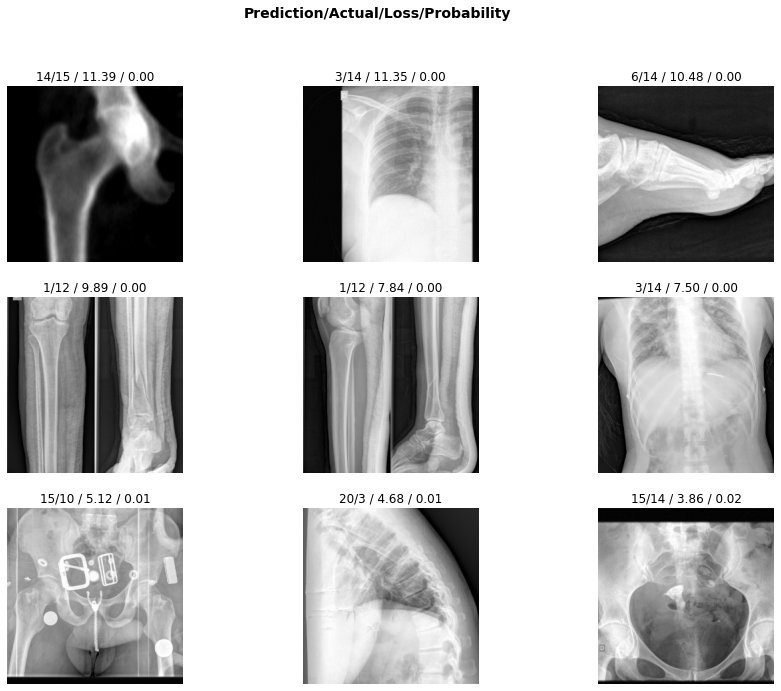

In [ ]:
# Mostrar muestras peor classificadas
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

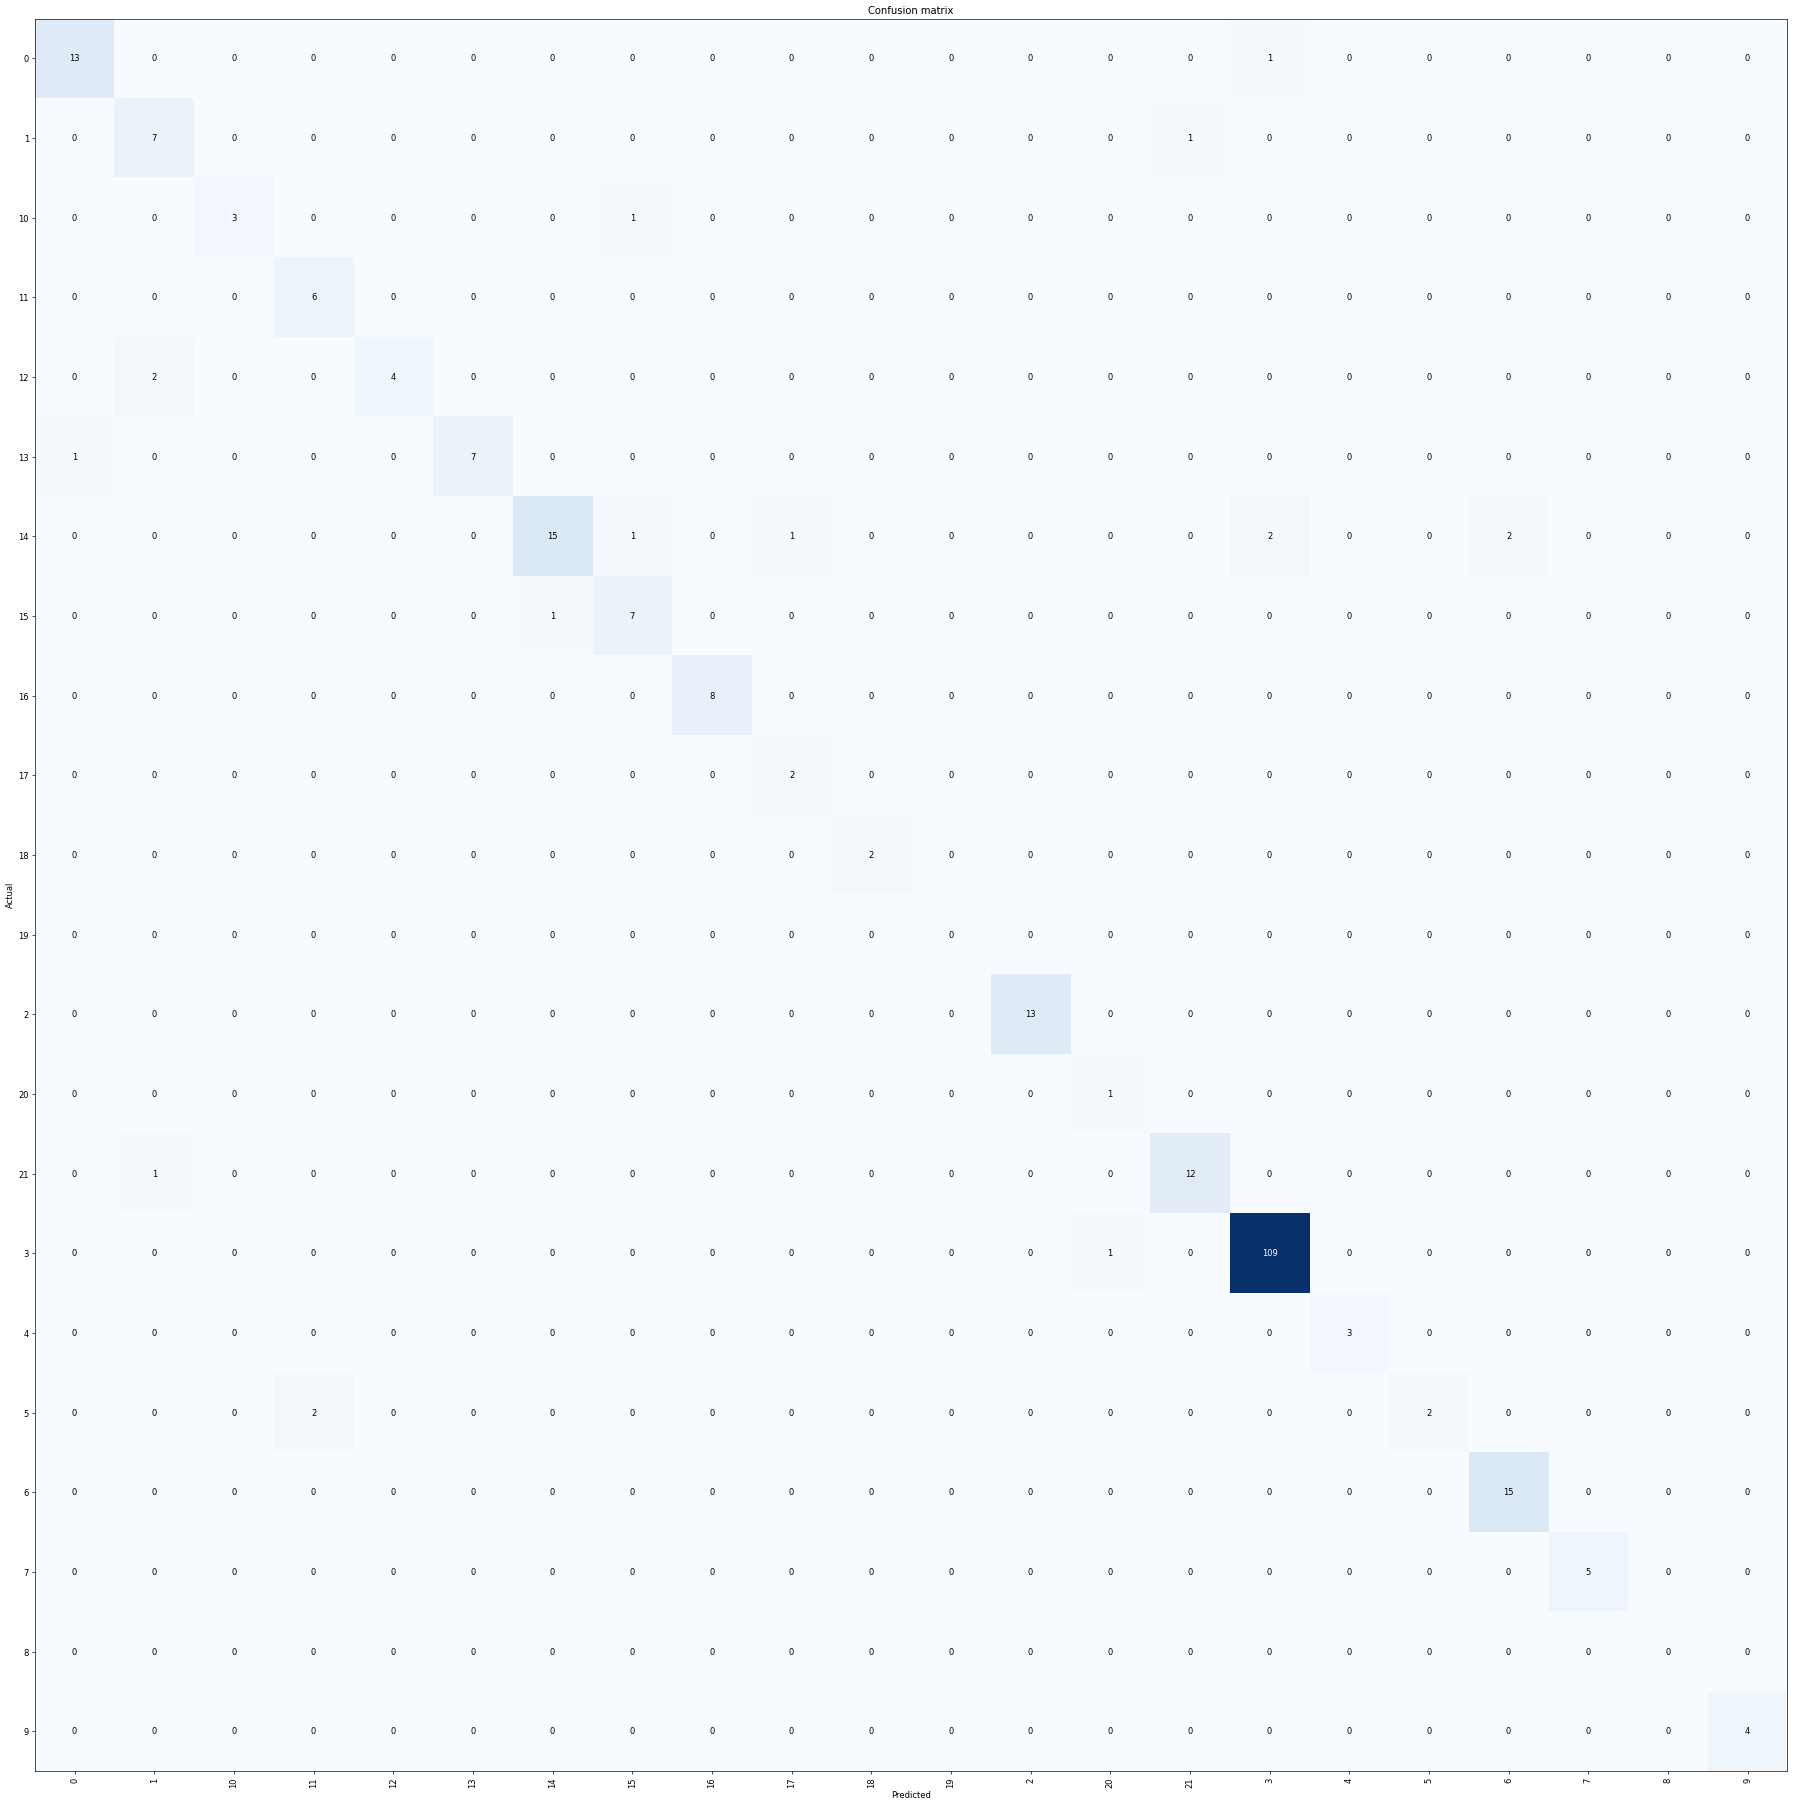

In [ ]:
# Show confusion matrix
interp.plot_confusion_matrix(figsize=(30,30), dpi=60)

In [ ]:
# Show most confused classes
interp.most_confused(min_val=2)

[('12', '1', 2), ('14', '3', 2), ('14', '6', 2), ('5', '11', 2)]

In [ ]:
[('12', '1', 2), ('14', '3', 2), ('14', '6', 2), ('5', '11', 2)]